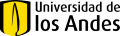

<span style="font-family:Cambria Math">
    
# Micro-proyecto 1. Generación de paleta de colores a partir de imágenes con técnicas de *machine learning* no supervisado

## Contexto
Este proyecto busca desarrollar una aplicación basada en *machine learning* que permita generar automáticamente paletas de colores a partir de imágenes. Esta herramienta ayudará a diseñadores, artistas y creadores de contenido a seleccionar combinaciones cromáticas armoniosas y funcionales de manera rápida y eficiente. La aplicación identificará los tonos dominantes y analizará sus relaciones cromáticas para crear paletas visualmente atractivas, optimizando la calidad y el impacto de la comunicación visual en diversos campos como el diseño, el arte, la psicología y el marketing.

***

También este micro-proyecto busca retar a los estudiantes para aplicar los conocimientos adquiridos en las semanas 1-4 del curso "*Machine Learning* No Supervisado".

***

## Objetivo
Desarrollar un método, basado en técnicas de agrupación, que permita extraer los tonos de
una imagen y generar un muestrario de los colores presentes en esta
</span>

***

<div class="alert alert-block alert-info">
<bNotar:</b >

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Núñez Campos para entrega el 24 de febrero.**
</div24></span>

***

<div class="alert alert-block alert-info">
<bNotar:</b >

**1. Utilizar la heurística para encontrar los mejores epsilon y min samples** (Responsable: Andrés)

**2.Visualización t-SNE** (Responsable: Andrés, hablarlo con los monitores, profesora)

**3. Implementar Aglomerativo** (Responsable: Jordan)

**4. Visualización de las siluetas** (Responsable: Jordan)

**5. Descripciones, textos, justificaciones** (Responsable: Jordan, Andrés)


</div24></span>

***

<span style="font-family:Cambria Math">

## Desarrollo
Se empieza por el cargue de las librerias a usar y con la el *pipeline* para la preparación de los datos
</span>

In [146]:
from skimage import io, color, transform
from skimage.transform import rescale
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Versiones de las librerías utilizadas:

In [52]:
from importlib.metadata import version
version('scikit-image')
for library in ['scikit-image', 'matplotlib', 'numpy', 'scikit-learn', 'scipy']:
  print(library, ": ", version(library))

scikit-image :  0.25.1
matplotlib :  3.10.0
numpy :  1.26.4
scikit-learn :  1.6.1
scipy :  1.13.1


***

<span style="font-family:Cambria Math">
Para el cargue y preparación de los datos se eligió utilizar el espacio de color CIELAB. A continuación se explica con un poco más de detalle de qué se trata este modelo:
</span>

<span style="font-family:Cambria Math">

## Espacio de color CIELAB

El espacio de color CIELAB es un modelo cromático usado para describir todos los colores que puede percibir el ojo humano (`rojo`, `verde`, `azul` y `amarillo`) y tiene la intención de mimetizar la respuesta no lineal del sistema visual.

Este espacio de color utiliza tres dimensiones:
- Luminosidad `L*` (negro a blanco), con rango continuo `0:100`
- Eje verde-rojo `a*`, con rango continuo `-128:127`
- Eje azul-amarillo `a*`, con rango continuo `-128:127`
  
Entonces el cálculo de distancias euclidianas entre colores es válido en este espacio.

La función `color.rgb2lab` de la librería `skimage` permite transformar de un espacio de color RGB a uno CIELAB.
- El argumento `illuminant` puede ser “A”, “B”, “C”, “D50”, “D55”, “D65”, “D75”, “E”. `'D65'` es el valor por defecto.
- `color.rgb2lab` realiza la conversión entre RGB y CIELAB de forma segura, manejando los rangos apropiadamente

</span>

<span style="font-family:Cambria Math">
A continuación se muestra un ejemplo de como se realiza esta transformación:
</span>

In [53]:
rgb_test = np.array([100, 50, 125]).astype(np.uint8)
color.rgb2lab(rgb_test)
# Coincide con los resulados de http://colormine.org/convert/rgb-to-lab

array([ 30.57176673,  36.06177058, -33.60828633])

***

<span style="font-family:Cambria Math">

## Preprocesamiento

Para la construcción del pipeline de pre-procesamiento de los datos hay que considerar que estamos trabajando con imágenes. Por lo tanto, no se requiere de quitar *outlayers* y para el correcto funcionamiento de los modelos hay que tener datos escalados.

También es necesario re-escalar las imágenes, esto permite un mejor uso de los recursos de procesamiento ya que al final cada pixel se convertirá en un dato. Nos aseguramos de mantener el rango de colores original que es lo que más nos interesa para efecto de la construcción de la paleta de colores, y se realiza un "suavizado" durante el escalado ya que cuando se reduce el tamaño de una imagen, se pueden tener efectos no deseados como el aliasing (escalones o bordes dentados). Con el parámetro anti_aliasing=True aplica un filtro de suavizado Gaussiano antes del escalado, reduciendo estos defectos.

</span>

In [54]:
# Downsampling
def reescalar_img(img: np.ndarray, factor: float):
    img_rescaled = rescale(
        img,
        scale=factor,
        channel_axis=2, # especificar cuál es el canal de colores # TEST
        anti_aliasing=True, # suavizar durante el escalado
        preserve_range=True # mantener el rango de colores original
    )
    return img_rescaled.astype(img.dtype)

***
<span style="font-family:Cambria Math">

Se utiliza el comando `imread` de `skimage.io` para cargar la imagen y después de reescalarla se hace la transformación de la imágen para tenerla en formato RGB y CIELAB

</span>

In [55]:
# Cargar img reescalada en ambos espacios de color: RGB y LAB
def cargar_img_RGB_LAB_downsample(imgpath: str, factor: float = 0.25):
    rgb = io.imread(imgpath)
    rgb = reescalar_img(rgb, factor)
    lab = color.rgb2lab(rgb)
    return rgb, lab

***
<span style="font-family:Cambria Math">

También es necesario re-estructurar los datos para poder trabajar los pixeles como filas y los canales como columnas:

</span>

In [35]:
# Obtener data tabular: pixeles como filas y CIELAB como columnas
def img_to_tabular(img: np.ndarray):
    return img.reshape(-1, img.shape[-1])

In [ ]:
# Obtener data tabular pero que las columnas sean los pixeles y las filas el número de samples
def img_to_tabular2(img: np.ndarray):
   # return img.reshape(-1, img.shape[-1])

***
<span style="font-family:Cambria Math">

Se definen las funciones de estandarización y su respectiva inversa, para más adelante usarla en cada corrida del modelo. Esto se incorporará en el *pipeline* del modelo por facilidad.

</span>

In [119]:
def estandarizar(X: np.ndarray):
    scaler = StandardScaler()
    return scaler.fit_transform(X), scaler

In [120]:
def des_estandarizar(X: np.ndarray, scaler: object):
     return scaler.inverse_transform(X)




***
<span style="font-family:Cambria Math">

## Clustering

Considerar esta métrica https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.deltaE_cie76

Para los modelos de agrupación se va a medir el *silhoutte score* de tres modelos: K-Medias (algoritmo basado en centroides), MeanShift (algoritmo híbrido),  Agrupación Aglomerativa (algoritmo jerárquico) y DBSCAN (algoritmo de densidad).

Se crean 4 funciones que nos permiten identificar los coeficientes de silueta de estos modelos pasando por un número de grupos entre 5 y 7 de acuerdo a las consideraciones del microproyecto (con excepción de MeanShift el cual no requiere como insumo el número de *clusters*).

</span>

In [121]:
# Selección de Kmeans con base en silhouette_score
def KMeans_silhouette(X: np.ndarray, Kmin: int = 5, Kmax: int = 7):

    modelos = np.array([])
    silhouette_scores = np.array([])
    X, scaler =  estandarizar(X)
    for k in range(Kmin, Kmax+1):
        modelo = KMeans(n_clusters=k, max_iter=300, n_init=10) #, n_jobs=-1)
        modelo.fit(X)
        modelos = np.append(modelos, modelo)
        silhouette_scores = np.append(silhouette_scores,silhouette_score(X, modelo.labels_))

    [print("Modelo KMeans K=", i+5, " --> Silhouette Score:", score) for (i,score) in enumerate(silhouette_scores)]

    mejor_modelo = modelos[silhouette_scores.argmax()]
    mejor_k = len(mejor_modelo.cluster_centers_)
    centroides = des_estandarizar(mejor_modelo.cluster_centers_,scaler)
    centroids_RGB_img = color.lab2rgb(centroides).reshape((1,mejor_k,3))
    centroides_no_reshape = color.lab2rgb(centroides)
    print("**Mejor modelo KMeans**")
    print("Número de clusters:", mejor_k)

    return centroids_RGB_img, mejor_modelo.labels_, centroides_no_reshape

In [123]:
# Selección de MeanShift con base en silhouette_score
def MeanShift_silhouette(X: np.ndarray, quantiles:list):

    modelos = np.array([])
    silhouette_scores = np.array([])
    clusters = np.array([])
    X, scaler =  estandarizar(X)

    for q in quantiles:
      bandwidth = estimate_bandwidth(X, quantile= q, n_samples=100)
      modelo = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs= -1)
      modelo.fit(X)
      modelos = np.append(modelos, modelo)
      n = len(modelo.cluster_centers_)
      clusters = np.append(clusters,n)
      if n >= 1 :
        silhouette_scores = np.append(silhouette_scores,silhouette_score(X, modelo.labels_))
      else:
        silhouette_scores = np.append(silhouette_scores,-1)

    [print("Modelo MeanShift K=", clusters[i]," Quantile =", quantiles[i] ," --> Silhouette Score:", score) for (i,score) in enumerate(silhouette_scores)]

    mejor_modelo = modelos[silhouette_scores.argmax()]
    mejor_k = len(mejor_modelo.cluster_centers_)
    centroides = des_estandarizar(mejor_modelo.cluster_centers_,scaler)
    centroids_RGB_img = color.lab2rgb(centroides).reshape((1,mejor_k,3))
    centroides_no_reshape = color.lab2rgb(centroides)
    print("**Mejor modelo MeanShift**")
    print("Número de clusters:", mejor_k, "Quantile =", quantiles[silhouette_scores.argmax()])

    return centroids_RGB_img, mejor_modelo.labels_, centroides_no_reshape

In [126]:
# Selección de DBSCAN con base en silhouette_score
def DBSCAN_silhouette(X: np.ndarray,  eps_list: list, min_samples_list: list, metric: str ='euclidean'):

    modelos, silhouette_scores, eps_scores, min_samples_scores, num_clusters = np.array([]),np.array([]), [], [], []
    X, scaler =  estandarizar(X)
    # Definimos la búsqueda exhaustiva con dos ciclos
    # El primero recorre todos los valores de épsilon
    for i in range(len(eps_list)):
        # Y el segundo recorre todos los valores de min_samples
        for j in range(len(min_samples_list)):
            eps_i = eps_list[i]
            min_samples_j = min_samples_list[j]
            eps_scores.append(eps_i)
            min_samples_scores.append(min_samples_j)
            # Definimos un modelo de DBSCAN con los valores actuales
            modelo_ij = DBSCAN(eps=eps_i, min_samples=min_samples_j, metric=metric, n_jobs=-1)
            # Entrenamos el modelo
            modelo_ij.fit(X)
            labels_ij = modelo_ij.labels_
            num_clusters_ij = len(set(labels_ij))
            num_clusters.append(num_clusters_ij)
            modelos = np.append(modelos,modelo_ij)
            # Almacenamos el coeficiente de la silueta
            # Si tenemos un número de clústeres mayor a 1, el coeficiente de la silueta está definido
            if num_clusters_ij > 1:
                score = silhouette_score(X, labels_ij)
                silhouette_scores = np.append(silhouette_scores,score)
            # Si DBSCAN retorna un solo clúster, el coeficiente de la silueta no está definido
            else:
                silhouette_scores = np.append(silhouette_scores,-1)

    [print("Modelo DBSCAN K=", num_clusters[i],"Epsilon=",eps_scores[i],"Min Samples = ",min_samples_scores[i], " --> Silhouette Score:", silhouette_scores[i]) for i in range(len(silhouette_scores))]

    mejor_modelo = modelos[silhouette_scores.argmax()]

    labels = mejor_modelo.labels_
    unique_labels = set(labels)
    # Calcular "centroides" como el promedio de los core points por cluster
    centroids = np.array([X[labels == k].mean(axis=0) for k in unique_labels])
    centroids = des_estandarizar(centroids,scaler)
    mejor_k = len(centroids)
    centroids_RGB_img = color.lab2rgb(centroids).reshape((1,mejor_k,3))
    centroides_no_reshape = color.lab2rgb(centroids)
    print("**Mejor modelo DBSCAN**")
    print("Número de clusters:", mejor_k, "Epsilon:",eps_scores[silhouette_scores.argmax()],"Min Samples = ",min_samples_scores[silhouette_scores.argmax()])

    return centroids_RGB_img, mejor_modelo.labels_, centroides_no_reshape

## Paleta de colores + PCA + t-SNE

In [143]:
def generar_paleta(imgpath: str, factor:float = 0.05, modelo: str ='KMeans'):
    rgb_1, lab_1 = cargar_img_RGB_LAB_downsample(imgpath, factor=factor)
    lab_1_tabular = img_to_tabular(lab_1)

    if modelo == 'KMeans':
        paleta, labels, centers = KMeans_silhouette(lab_1_tabular)
    elif modelo == 'MeanShift':
        # Valores de Quantiles
        quan_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
        paleta, labels, centers = MeanShift_silhouette(lab_1_tabular,quan_list)
    elif modelo == 'DBSCAN':
        # Valores de Épsilon
        eps_list = [ 0.65, 0.7, 0.75, 0.8,0.85]
        # Valores del mínimo de puntos
        min_samples_list = [4, 5, 6, 7]
        paleta, labels, centers = DBSCAN_silhouette(lab_1_tabular, eps_list,min_samples_list)
    elif modelo == 'Aglomerativo':
        #Pendiente
        print("Pendiente")
    else:
        print("Modelo no reconocido")

    # Imagen reescalada + Paleta
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(rgb_1)
    ax[1].imshow(paleta)

    # Imagen Pintada con los Colores de la Paleta
    img_segmented = centers[labels]
    img_segmented = img_segmented.reshape(rgb_1.shape)
    ax[2].imshow(img_segmented)

    print("Imagen reescalada a",str(rgb_1.shape[0])+"x"+str(rgb_1.shape[1]),"pixeles")


    #visualización_TSNE(lab_1_tabular)

    # t-SNE
    #...

Modelo DBSCAN K= 1 Epsilon= 0.65 Min Samples =  4  --> Silhouette Score: -1.0
Modelo DBSCAN K= 2 Epsilon= 0.65 Min Samples =  5  --> Silhouette Score: 0.38562861093154105
Modelo DBSCAN K= 2 Epsilon= 0.65 Min Samples =  6  --> Silhouette Score: 0.2486885840300791
Modelo DBSCAN K= 2 Epsilon= 0.65 Min Samples =  7  --> Silhouette Score: 0.2565126100250836
Modelo DBSCAN K= 1 Epsilon= 0.7 Min Samples =  4  --> Silhouette Score: -1.0
Modelo DBSCAN K= 2 Epsilon= 0.7 Min Samples =  5  --> Silhouette Score: 0.38562861093154105
Modelo DBSCAN K= 2 Epsilon= 0.7 Min Samples =  6  --> Silhouette Score: 0.2680136662360806
Modelo DBSCAN K= 2 Epsilon= 0.7 Min Samples =  7  --> Silhouette Score: 0.2643111126700551
Modelo DBSCAN K= 1 Epsilon= 0.75 Min Samples =  4  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.75 Min Samples =  5  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.75 Min Samples =  6  --> Silhouette Score: -1.0
Modelo DBSCAN K= 2 Epsilon= 0.75 Min Samples =  7  --> Silho

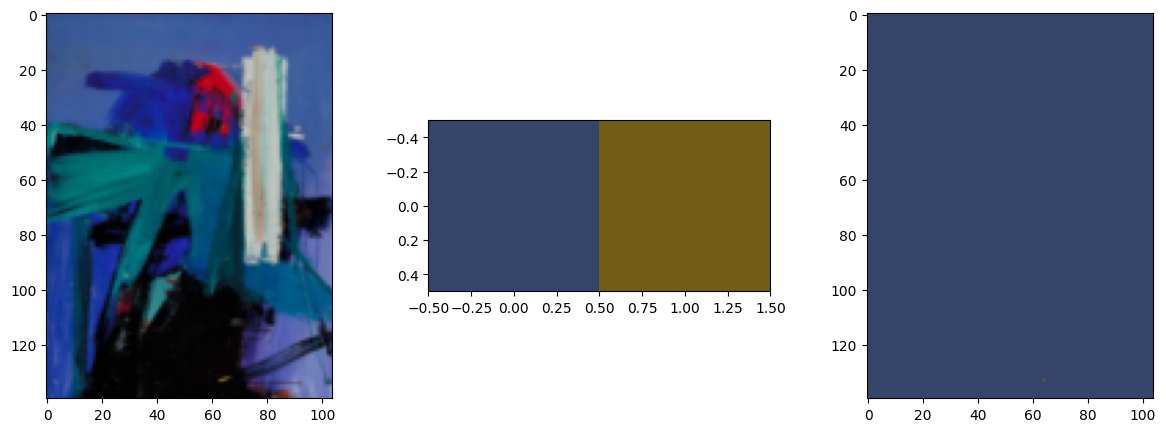

In [145]:
%time generar_paleta("img/franz-kline_blueberry-eyes-1960.jpg", factor=0.075, modelo = "DBSCAN")

Modelo DBSCAN K= 1 Epsilon= 0.65 Min Samples =  4  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.65 Min Samples =  5  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.65 Min Samples =  6  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.65 Min Samples =  7  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.7 Min Samples =  4  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.7 Min Samples =  5  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.7 Min Samples =  6  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.7 Min Samples =  7  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.75 Min Samples =  4  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.75 Min Samples =  5  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.75 Min Samples =  6  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.75 Min Samples =  7  --> Silhouette Score: -1.0
Modelo DBSCAN K= 1 Epsilon= 0.8 Min Samples =  4  --> Silhouette Sco

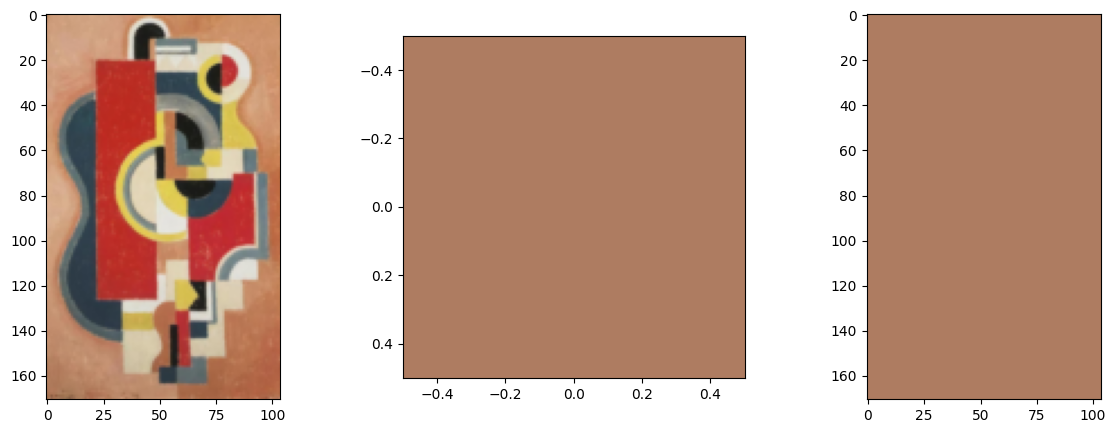

In [147]:
%time generar_paleta("img/adolf-fleischmann_hommage-delaunay-et-gleizes-1938.jpg", factor=0.075,modelo = "DBSCAN")

Modelo KMeans K= 5  --> Silhouette Score: 0.32042150221880067
Modelo KMeans K= 6  --> Silhouette Score: 0.3058517087938876
Modelo KMeans K= 7  --> Silhouette Score: 0.31358184632781494
**Mejor modelo KMeans**
Número de clusters: 5
Imagen reescalada a 138x172 pixeles
CPU times: user 24.4 s, sys: 11.1 s, total: 35.4 s
Wall time: 26.7 s


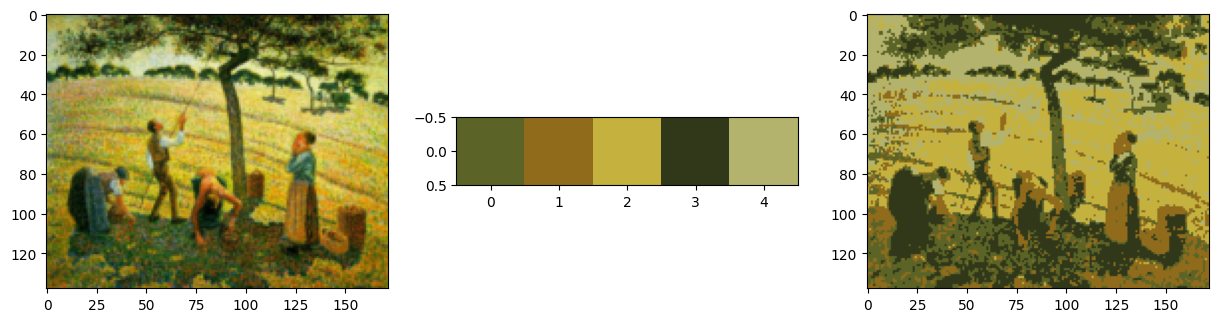

In [110]:
%time generar_paleta("img/camille-pissarro_apple-picking-at-eragny-sur-epte-1888.jpg", factor=0.10)

Modelo KMeans K= 5  --> Silhouette Score: 0.39812280338037814
Modelo KMeans K= 6  --> Silhouette Score: 0.4075058335276064
Modelo KMeans K= 7  --> Silhouette Score: 0.38483280325956154
**Mejor modelo KMeans**
Número de clusters: 6
Imagen reescalada a 138x186 pixeles
CPU times: user 27.9 s, sys: 12 s, total: 39.8 s
Wall time: 30.7 s


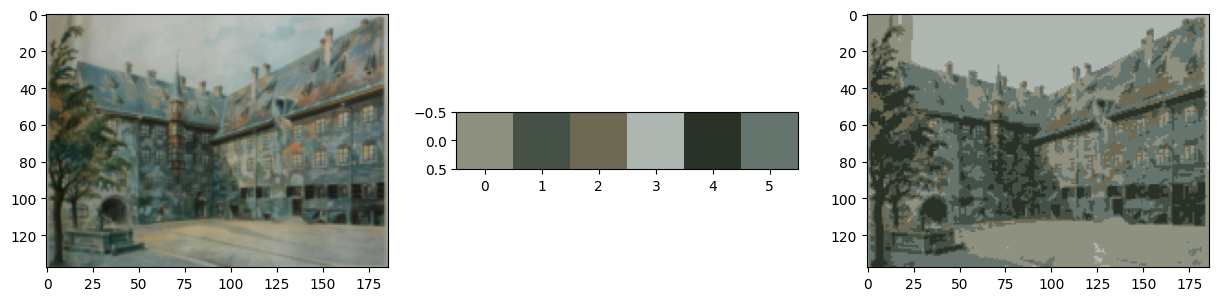

In [109]:
%time generar_paleta("img/adolf-hitler_the-courtyard-of-the-old-residency-in-munich-1913.jpg", factor=0.10)

***
<span style="font-family:Cambria Math">

## Visualización t-SNE

Una vez reconocidos los mejores modelos para cada imagen se obtiene la paleta de cada imagen y se visualiza en un mapa 2-D gracias a la función t-SNE

</span>

In [ ]:
def visualización_TSNE(lista_imagenes: list, lista_modelos):

   bd_imagenes = []
   for img in lista_imagenes:
      rgb_1, lab_1 = cargar_img_RGB_LAB_downsample(img)
      lab_1_tabular = img_to_tabular(lab_1)

      # Definir el tamaño deseado (n, m)
      nuevo_tamaño = (100, 100)  # (alto, ancho) en píxeles
      # Redimensionar la imagen
      rgb_2 = transform.resize(rgb_1, nuevo_tamaño, anti_aliasing=True)
      lab_2 = transform.resize(lab_1, nuevo_tamaño, anti_aliasing=True)
      lab_2_tabular = img_to_tabular(lab_2)

      if modelo == 'KMeans':
            paleta, labels, centers = KMeans_silhouette(lab_1_tabular)
        elif modelo == 'MeanShift':
            # Valores de Quantiles
            quan_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
            paleta, labels, centers = MeanShift_silhouette(lab_1_tabular,quan_list)
        elif modelo == 'DBSCAN':
            # Valores de Épsilon
            eps_list = [ 0.65, 0.7, 0.75, 0.8,0.85]
            # Valores del mínimo de puntos
            min_samples_list = [4,5,6, 7]
            paleta, labels, centers = DBSCAN_silhouette(lab_1_tabular, eps_list,min_samples_list)
        elif modelo == 'Aglomerativo':
            #Pendiente
            print("Pendiente")
        else:
            print("Modelo no reconocido")


# Referencias

---
- https://en.wikipedia.org/wiki/CIELAB_color_space#Perceptual_differences
- https://es.wikipedia.org/wiki/Espacio_de_color_Lab
- https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2lab
- https://stackoverflow.com/questions/52459146/what-should-be-the-input-to-skimage-color-rgb2lab